## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


In [1]:
import numpy as np
import cv2
import glob
import matplotlib
import matplotlib.pyplot as plt

from src.binary_lane_filter import apply_road_lane_binary_filter
from src.lib import abs_sobel_thresh, abs_thresh
from src.curvature import estimate_lane_curve_radius_m

from src.warp import ImageWarp

%matplotlib qt
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10, 5]



## Camera Callibration

Callibration of the camera is done using chessboard images provided in the `camera_cal` folder. 

I have used object possitions that were provided for each image.

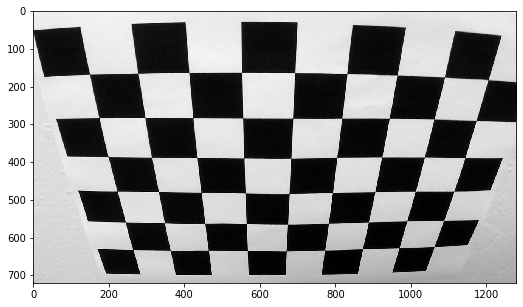

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

img = cv2.imread('camera_cal/calibration2.jpg')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap="gray")

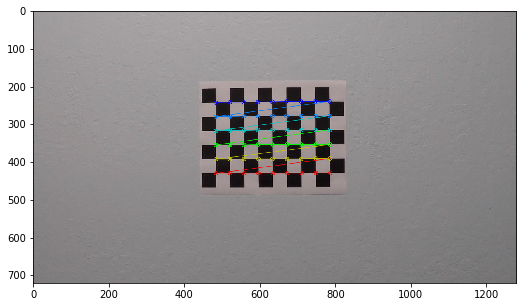

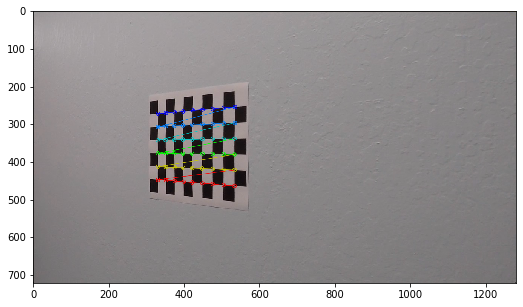

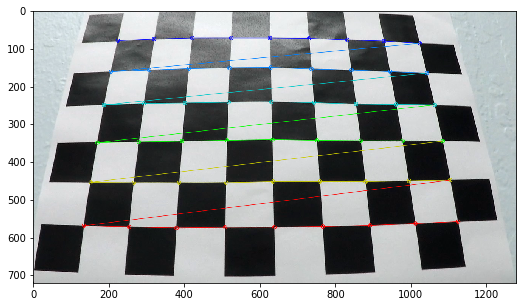

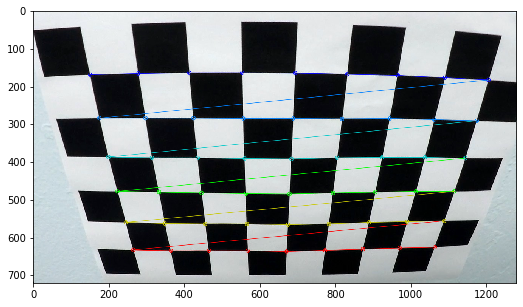

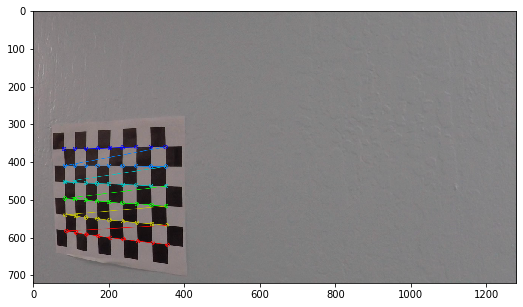

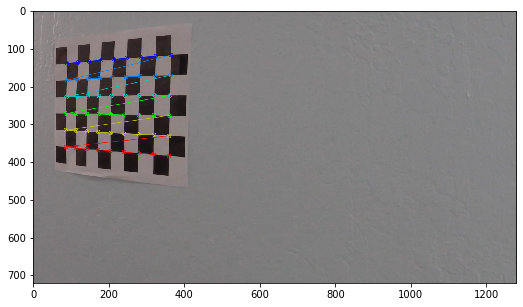

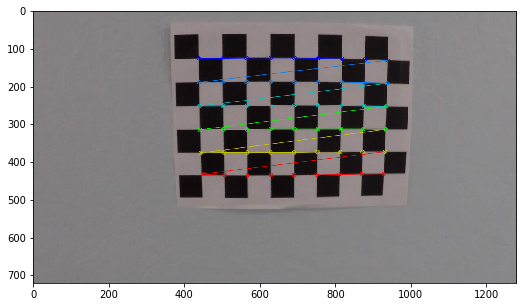

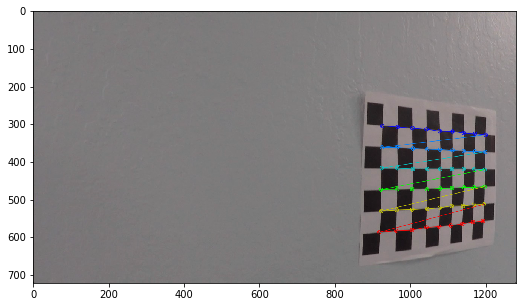

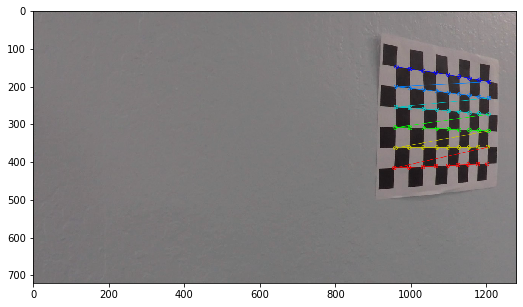

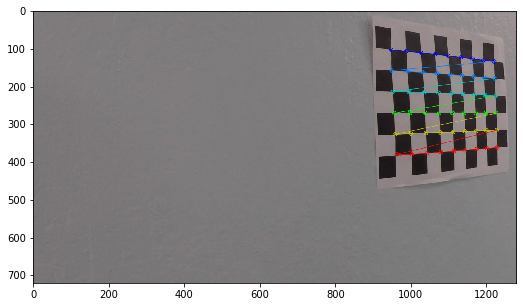

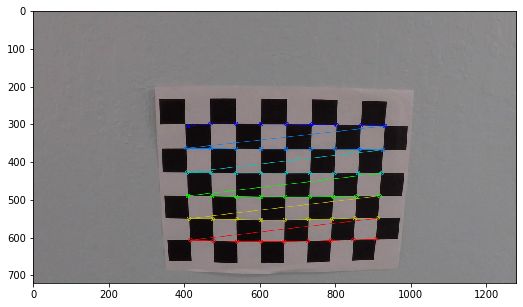

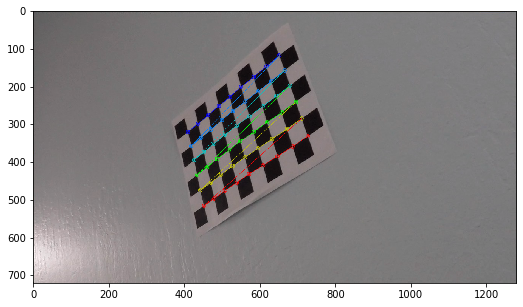

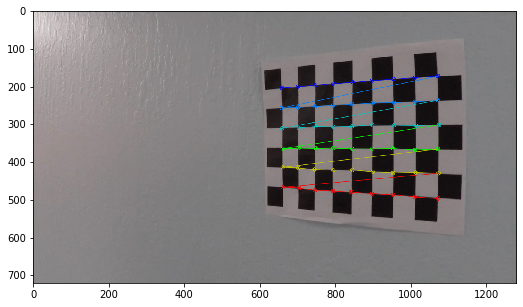

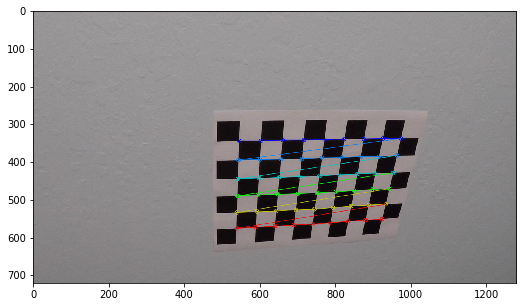

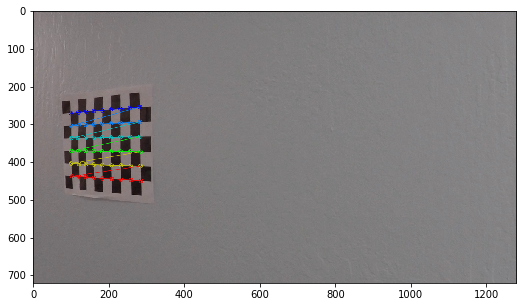

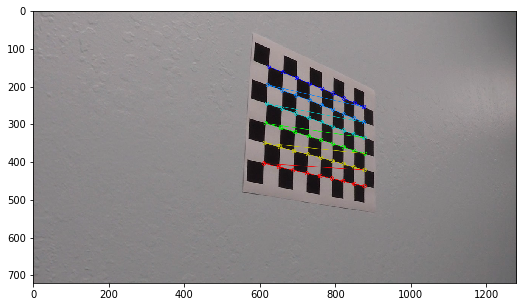

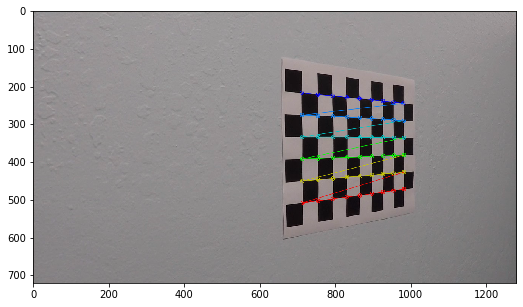

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')


board_size =  (9,6)


# Step through the list and search for chessboard corners
for fname in images:
    
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, board_size, None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, board_size, corners, ret)
        plt.imshow(img)
        plt.show()


In [4]:
# callibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_gray.shape[::-1], None, None)


True

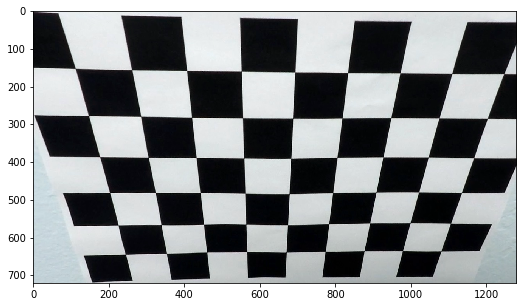

In [5]:
# Check how undistorted image looks
img = cv2.imread('camera_cal/calibration2.jpg')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

dst = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(dst)

cv2.imwrite(
    "writeup_images/calibration2.jpg", 
    dst
)

## Apply filters and masking to identify lane pixels

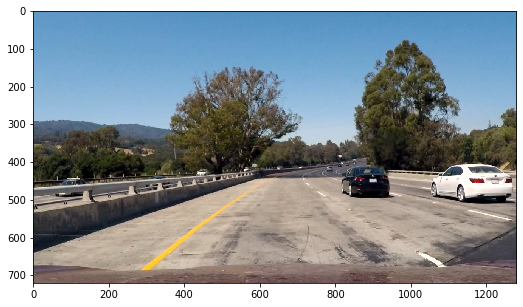

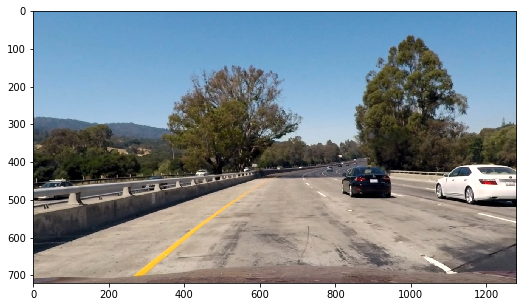

True

In [6]:

img_original = cv2.imread('test_images/test1.jpg')
img_original_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
plt.imshow(img_original_rgb)
plt.show()

img = cv2.undistort(img_original, mtx, dist, None, mtx)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()


cv2.imwrite(
    "writeup_images/undistort_original.jpg", 
    img_original
)
cv2.imwrite(
    "writeup_images/undistort_output.jpg", 
    img
)

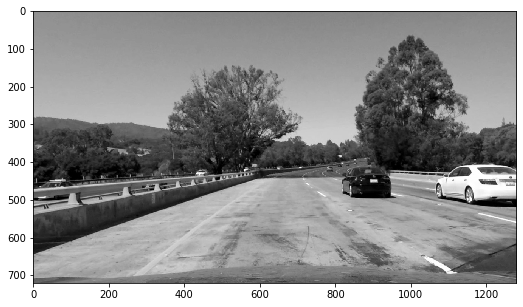

In [7]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap = "gray")

## Explore saturation layer

Saturation layer based filters help to identify pixels on the yellow line. 

This layer is also very robust for processing difficult images with shadows for example, as saturation does not change with light intensity. 

We can see that yellow left line can be clearly seen on the grayscale of saturation layer below.

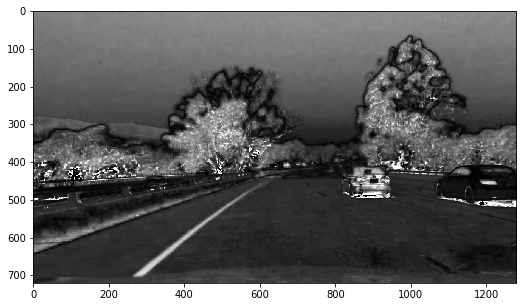

In [8]:
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
S = hsv[:,:, 1]
plt.imshow(S, cmap = "gray")

Saturation layer compensates for shadows and color intensity changes. 
It also allows for good detection of the yellow lines wich is usually a problem in gray images. 

True

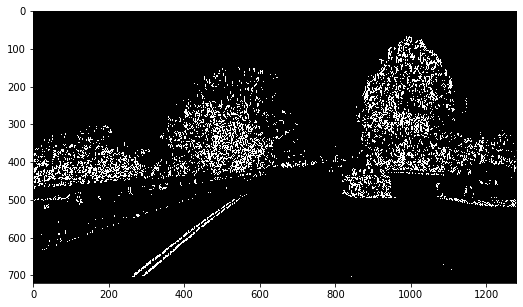

In [9]:
# Apply x Sobel on S
s_grad_x_binary = abs_sobel_thresh(S, orient='x', thresh_min=20, thresh_max=100)

plt.imshow(s_grad_x_binary, cmap='gray')

cv2.imwrite(
    "writeup_images/binary_mask_s_grad_x.jpg", 
    s_grad_x_binary * 255
)

True

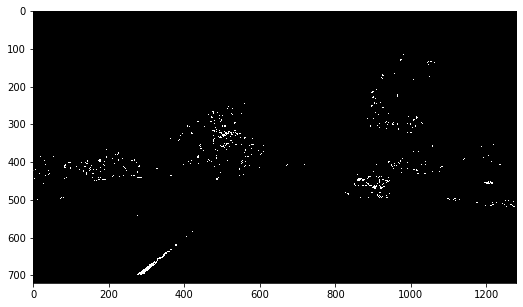

In [10]:
# Apply binary thresholding on S
s_binary_threshold = abs_thresh(S, thresh_min=200, thresh_max=250)
    
plt.imshow(s_binary_threshold, cmap='gray')

cv2.imwrite(
    "writeup_images/binary_mask_s_threshold.jpg", 
    s_binary_threshold * 255
)

## Apply sobel and intensity threshold on color layer

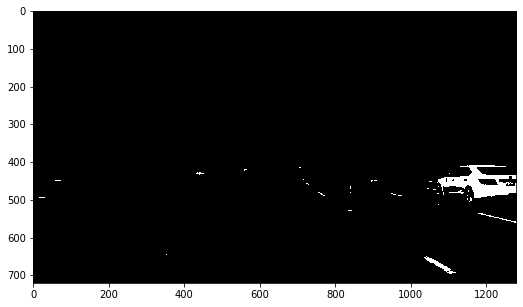

In [11]:
gray_binary = abs_thresh(gray, thresh_min=220, thresh_max=255)
plt.imshow(gray_binary, cmap='gray')


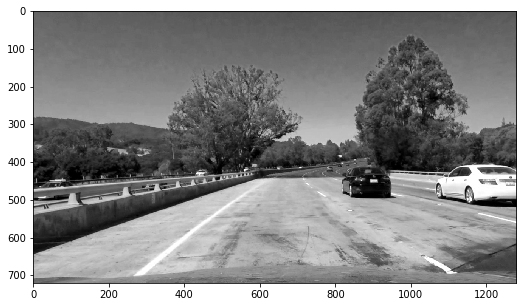

In [12]:
# Extract Red channel
R = img[:, :, 2]
plt.imshow(R, cmap = "gray")

True

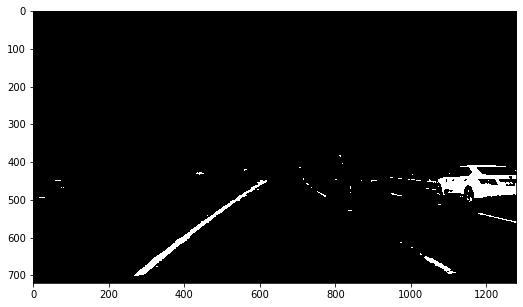

In [13]:
thresh_min=220
thresh_max=255

r_binary_threshold = abs_thresh(R, thresh_min=thresh_min, thresh_max=thresh_max)
plt.imshow(r_binary_threshold, cmap='gray')

cv2.imwrite(
    "writeup_images/binary_mask_r_threshold.jpg", 
    r_binary_threshold * 255
)

## Sobel on tne gray scale

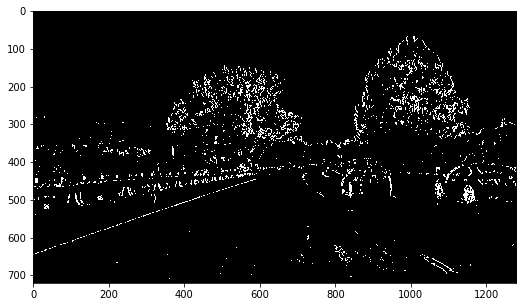

In [14]:
gray_grad_x_binary = abs_sobel_thresh(gray, orient='x', thresh_min=30, thresh_max=200)
plt.imshow(gray_grad_x_binary, cmap='gray')

## Sobel on tne Red channel

True

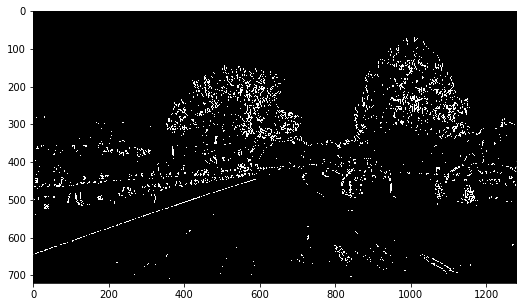

In [15]:
r_grad_x_binary = abs_sobel_thresh(R, orient='x', thresh_min=30, thresh_max=100)
plt.imshow(r_grad_x_binary, cmap='gray')

cv2.imwrite(
    "writeup_images/binary_mask_r_gradient_x.jpg", 
    r_grad_x_binary * 255
)

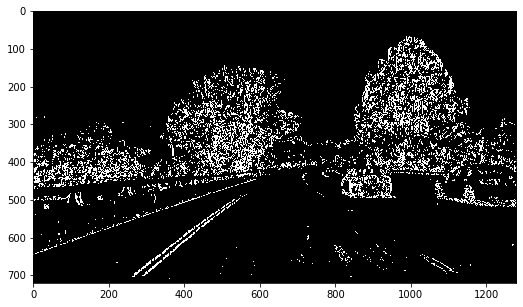

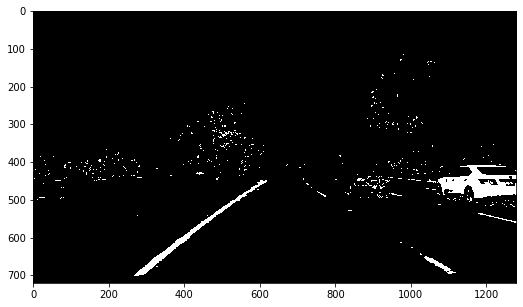

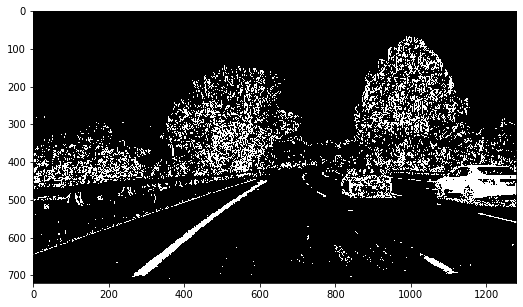

True

In [16]:
# combine binaries into resulting one

gray_binary

# Combine Results of Sobel in S and R layers
output_binary_sobel_sr = cv2.bitwise_or(s_grad_x_binary, r_grad_x_binary)
plt.imshow(output_binary_sobel_sr, cmap='gray')
plt.show()

output_binary_threshold_sr = cv2.bitwise_or(r_binary_threshold, s_binary_threshold)
plt.imshow(output_binary_threshold_sr, cmap='gray')
plt.show()


output_binary = cv2.bitwise_or(output_binary_sobel_sr, output_binary_threshold_sr)
plt.imshow(output_binary, cmap='gray')
plt.show()


cv2.imwrite(
    "writeup_images/binary_output.jpg", 
    output_binary * 255
)


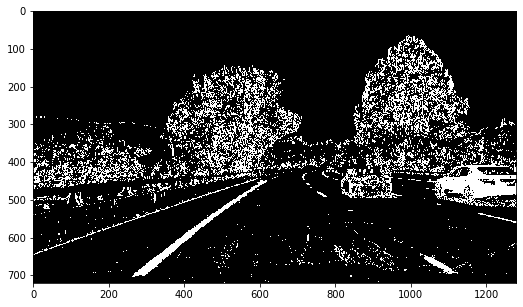

In [17]:
# check output of the binary filter function that was `productised` into lib files
output_binary = apply_road_lane_binary_filter(img)
plt.imshow(output_binary, cmap='gray')

If cars are filtered out by segmenting out the road ahead or perspective transformation, combined binary looks good enough to proceed with the next steps.

## Change image perspective to have a bird eye view on the road

First, we can use the straight lines image taken on the long stretch of the road to calibrate parameters of the perspective transformation.

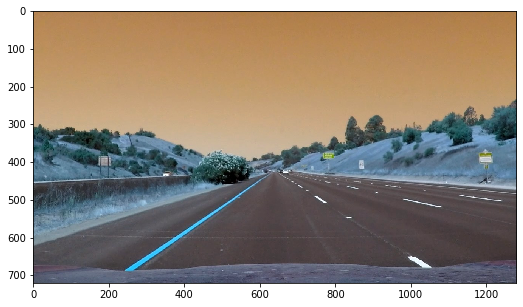

True

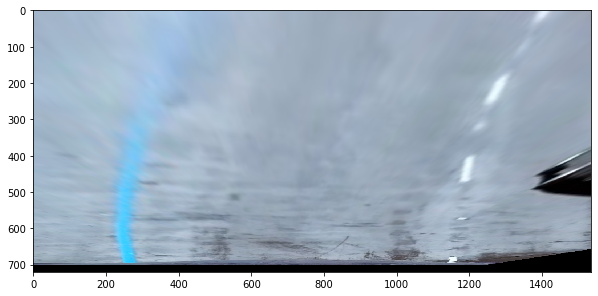

In [18]:
img_original = cv2.imread('test_images/straight_lines1.jpg') 

plt.imshow(img_original) 
plt.show()

src = np.float32([[500, 515], [760, 500], [200, 720], [1100, 720]])
dst = np.float32([[200, 500], [1100, 500], [200, 700], [1110, 700]])

warp = ImageWarp(src, dst)
  

warped = warp.top_view(img)
plt.imshow(warped)  
    
cv2.imwrite(
    "writeup_images/straight_lines1_warp.jpg", 
    warped
)


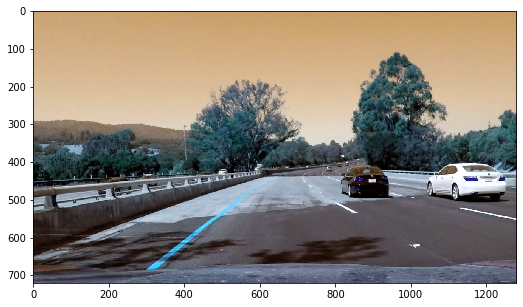

True

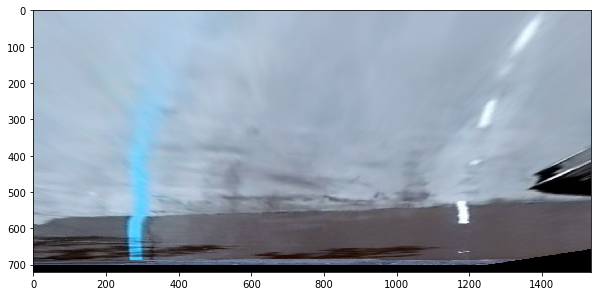

In [19]:
img_original = cv2.imread('test_images/test4.jpg') 

plt.imshow(img_original) 
plt.show()


warped = warp.top_view(img_original)
plt.imshow(warped)  

cv2.imwrite(
    "writeup_images/test4_warp.jpg", 
    warped
)


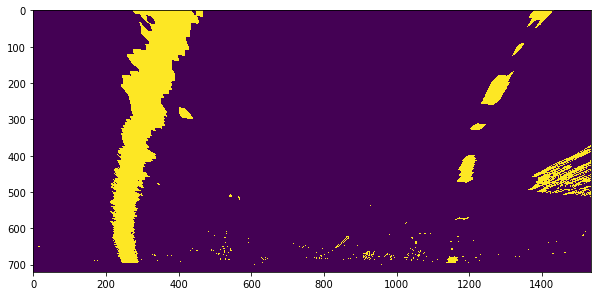

In [20]:
warped = warp.top_view(output_binary)
plt.imshow(warped) 

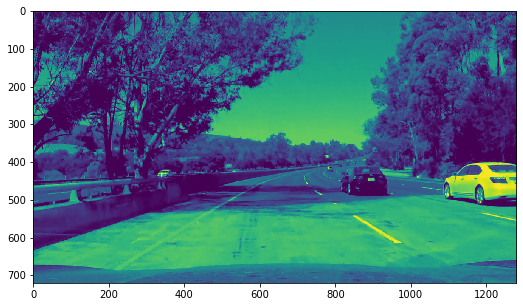

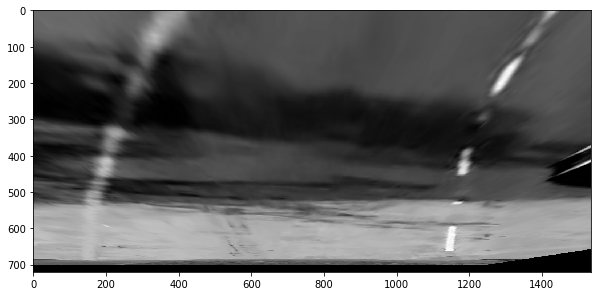

In [21]:
img_original = cv2.imread('test_images/test5.jpg') 
img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2GRAY)

plt.imshow(img_original) 
plt.show()


warped5 = warp.top_view(img_original)
plt.imshow(warped5, cmap = 'gray')  

In [22]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels



In [23]:
def smooth_array(x, N = 50):
    smooth = np.convolve(x, np.ones((N,))/N)[(N-1):]
    smooth_shifted = np.zeros(N // 2)
    smooth_shifted = np.append(smooth_shifted, smooth[:len(x) - N // 2])
    return smooth_shifted


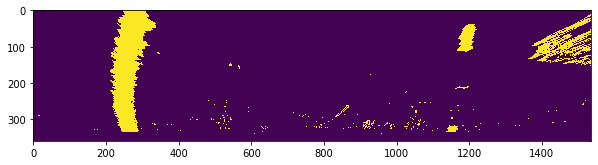

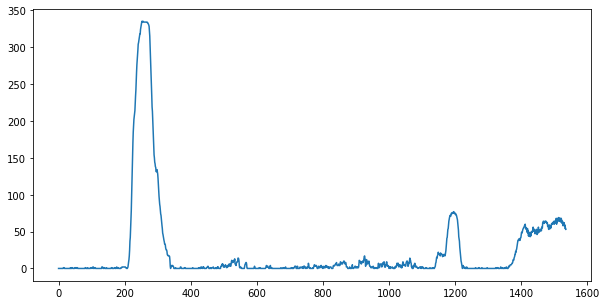

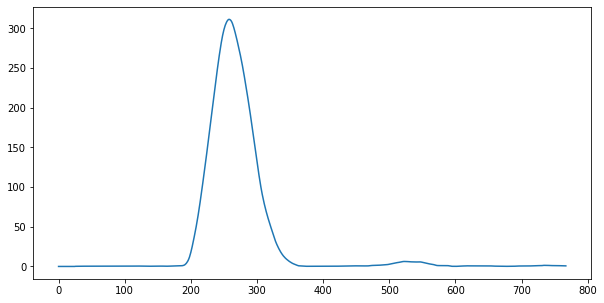

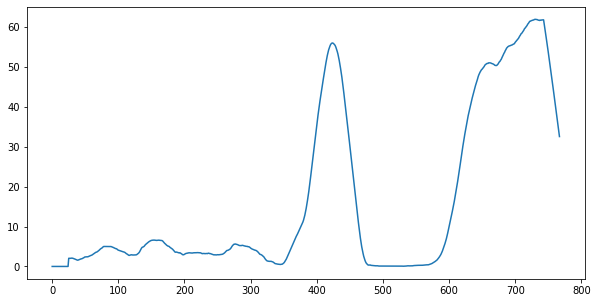

In [44]:
height, width = warped.shape

 
# identify the middle point for the lanes on the half of the image


plt.imshow(warped[height - height // 2:, :])
plt.show()
frequency = np.sum(warped[height - height // 2:, :], axis=0)
plt.plot(frequency)
plt.show()

hist_left = frequency[:width // 2]
hist_right = frequency[width // 2:]
N=50
hist_left_smooth = smooth_array(hist_left, 50)
plt.plot(hist_left_smooth)
plt.show()

hist_right_smooth = smooth_array(hist_right)
plt.plot(hist_right_smooth)
plt.show()

left_current = hist_left.argmax()
right_current = hist_right.argmax()

72


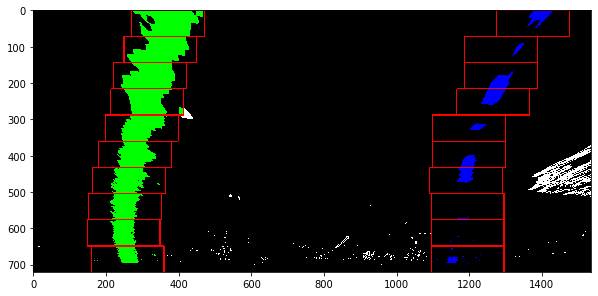

In [45]:

# nwindows
nwindows = 10
smooth_n = 10 # number of pixels for running average smoothing
margin = 100 # width of the lane window for visualisation


h = height // nwindows
print(h)

left_max_points = []
right_max_points = []

out_img = cv2.merge([warped * 255, warped * 255, warped * 255])
out_overlay = cv2.merge([warped * 0, warped * 0, warped * 0])
# Create an output image to draw on and visualize the result
#out_img = np.dstack((warped, warped, warped))*255

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

def find_lane_position(frequency, current, margin):
    """finds position of the lane using position of max value in the histogram."""
    
    width = len(frequency)
    window_right = 0
    window_left = 0
    if current + margin < width:
        window_right = current + margin
    else:
        print("adjusting window - to high, current = {current}, margin = {margin}".format(current = current, margin = margin))
        print("width {width}".format(width = width))
        window_right = width
    
    if current - margin > 0:
        window_left = current - margin
    else:
        print("adjusting window - to low")
        window_left = 0
    
    window = frequency[window_left: window_right]
    
    if np.max(window) > 20:
        #position = window.argmax() + current - margin
        position = weighted_lane_position(window) + current - margin
    else:
        position = current
    
    # here we can also add a check for number of 
    
    return position

def weighted_lane_position(frequency):
    rates = []
    for i in range(len(frequency)):
        rates.append(i * frequency[i] / np.sum(frequency))
    return int(sum(rates))
   

for window in range(nwindows):
    # Iterate over windows sliding on Y to find new window 
    # position in each step
     
    window_top = height - h * window
    window_bottom = height - h * (window + 1)
    y_position = (window_top + window_bottom) / 2
    frequency = np.sum(warped[window_bottom:window_top, :], axis=0)
  
    smooth = smooth_array(frequency, smooth_n)
    
    hist_left = smooth[:width // 2]
    #print("looking for left")
   
    left_position = find_lane_position(
        smooth[:width // 2],
        left_current,
        margin
    )

   
    right_position = find_lane_position(
        smooth[width // 2:],
        right_current,
        margin
    )
    
    x_min_left = left_position - margin
    x_max_left = left_position + margin
    
    
    x_min_right = right_position - margin + width // 2
    x_max_right = right_position + margin + width // 2
    
    
    left_window = out_img[window_bottom:window_top, x_min_left:x_max_left]
    left_window_warped = warped[window_bottom:window_top, x_min_left:x_max_left]
    left_window[np.where(left_window_warped == [1])] = [(0, 255,0)]
    
    right_window = out_img[window_bottom:window_top, x_min_right:x_max_right]
    right_window_warped = warped[window_bottom:window_top, x_min_right:x_max_right]
    right_window[np.where(right_window_warped == [1])] = [(0, 0, 255)]
    

    
    # draw windows around the new positions
    cv2.rectangle(
        out_img, 
        (x_min_left, window_top), 
        (x_max_left, window_bottom), 
        (255,0,0), 
        2
    )

    cv2.rectangle(
        out_img, 
        (x_min_right, window_top), 
        (x_max_right, window_bottom), 
        (255,0,0), 
        2
    )
    
      
    right_current = right_position
    left_current = left_position
    
    left_lane_inds.append((left_current, y_position))
    right_lane_inds.append((right_current + width // 2, y_position))
    
    # Find number of pixels in the window
    
    


plt.imshow(out_img)
plt.show()

In [46]:
out_img.shape

(720, 1536, 3)

### Use identified positions of window centers to fit a line

Positions of windows allow us to fit a polynom line using `np.polyfit` function. 

Polynom is defined like this:

> X = a * Y ** 2 + b * Y + c

Polynom is plotted with yellow lines.

(1196, 1196, 1196, 1191, 1199, 1199, 1266, 1287, 1287, 1376)
(260, 249, 253, 263, 281, 299, 314, 322, 350, 371)
(684.0, 612.0, 540.0, 468.0, 396.0, 324.0, 252.0, 180.0, 108.0, 36.0)


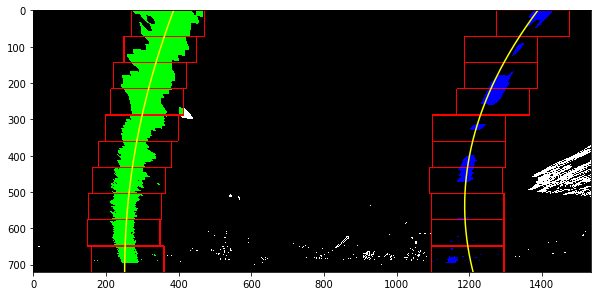

In [47]:
rightx, righty = zip(*right_lane_inds)
print(rightx)

right_fit = np.polyfit(righty, rightx, 2)

ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


# Polyfit left lane ids
leftx, lefty = zip(*left_lane_inds)
print(leftx)
print(lefty)
left_fit = np.polyfit(lefty, leftx, 2)

ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]


plt.imshow(out_img)
plt.plot(right_fitx, ploty, color='yellow')
plt.plot(left_fitx, ploty, color='yellow')


In [48]:
# Measure the curvature of the lanes

In [50]:
y = height

a = left_fit[0]
b = left_fit[1]
c = left_fit[2]
left_curverad = (1 + (2 *a*y + b) ** 2) ** (3/2) / abs(2 * a)
   
a = right_fit[0]
b = right_fit[1]
c = right_fit[2]    

right_curverad = (1 + (2 *a * y + b) ** 2) ** (3/2) / abs(2 * a)
   
print(left_curverad)
print(right_curverad)

1911.423875065556
789.2454089187734


## Curvature in meters

Now we can to calculate curvature of the road in meters by converting image pixels to meeters 
using given coefficients. 

In [51]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

y  = height * ym_per_pix

right_fit = np.polyfit(np.asarray(righty) * ym_per_pix, np.asarray(rightx) * xm_per_pix, 2)
a = right_fit[0]
b = right_fit[1]
c = right_fit[2]
right_curverad_m = (1 + (2 *a * y + b) ** 2) ** (3/2) / abs(2 * a)

left_fit = np.polyfit(np.asarray(lefty) * ym_per_pix,  np.asarray(leftx) * xm_per_pix, 2)
a = left_fit[0]
b = left_fit[1]
c = left_fit[2]


left_curverad_m = (1 + (2 *a*y + b) ** 2) ** (3/2) / abs(2 * a)

print(left_curverad_m)
print(right_curverad_m)

627.8121955093316
236.45569959564685


In [52]:
print(range(len([0, 1])))

range(0, 2)


In [53]:
left_lane_radius = estimate_lane_curve_radius_m(left_lane_inds, height)
right_lane_radius = estimate_lane_curve_radius_m(right_lane_inds, height)

In [54]:
print(left_lane_radius)
print(right_lane_radius)

627.8121955093316
236.45569959564685


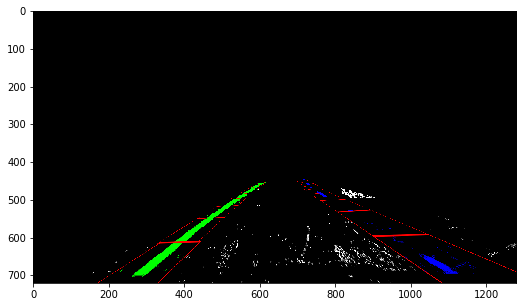

In [57]:
visual_output = warp.car_view(out_img)
plt.imshow(visual_output)  
